# Step #1 Load Training Data

In [564]:
import openai
import yaml
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_fscore_support as score
import seaborn as sns

# set the API Key 
yaml_file = open('API Keys/api_config_openai.yml', 'r')  
p = yaml.load(yaml_file, Loader=yaml.FullLoader)
openai.api_key = p['api_key']

# #show available openai language models (this tutorial uses davinci003)
# modellist = openai.Model.list()
# for i in modellist.data:
#     print(i.id)

# loads a tweets sentiment analysis dataset 
df_tweets = pd.read_csv('https://raw.githubusercontent.com/flo7up/public-relataly-analytics-data/main/NLP/sentiment/twitter_tweets_sentiment_classification/test.csv', sep=',')

# loads a stock market sentiment analysis dataset
df_stock_tweets = pd.read_csv('https://raw.githubusercontent.com/flo7up/public-relataly-analytics-data/main/NLP/sentiment/stock_market_sentiment_classification/test.csv', sep=',')

# loads a spam mail dataset into pandas dataframe
df_spam_mails = pd.read_csv('https://raw.githubusercontent.com/flo7up/public-relataly-analytics-data/main/NLP/email_spam_classification/test.csv', sep=',')

# Step #2 Zero Shot Learning Sentiment Analysis

In [565]:
def display_class_distribution(df, target_name):
    # visualize the classes in the dataset
    print(df.head(3))
    df[target_name].value_counts().plot(kind='bar')

def define_prompt(instruction, input_list):
    # count tokens in df
    tokencount = input_list.str.split().str.len().sum()
    print(f'tokens: {tokencount}')

    # define the prompt to the language model
    #inputs = df['Text'].tolist()
    n_inputs = len(input_list)
    print(f'Number of inputs: {n_inputs}')
    input_list = '|'.join(input_list)
    prompt = instruction + input_list
    print(f'Prompt: {prompt}')
    return prompt

def send_openai_request(prompt, max_tokens=800):
    # send the request to the openai language model
    response = openai.Completion.create(
        engine="text-davinci-003",
        prompt=prompt,
        max_tokens=max_tokens,
        n=1,
        stop=None,
        temperature=0.7
    )
    print(f"model response: {response}")
    return response

def check_response(list_response, n_inputs):
    # check if the number of classifications matches the number of inputs
    len_response = len(list_response)
    print(f'length: {len_response}')
    if len_response != n_inputs:
        print('Error: The number of classifications does not match the number of inputs.')
    else :
        print('Success: The number of classifications matches the number of inputs.')

def clean_response(response):
    #get the text from the response
    responsetext = response['choices'][0]['text']

    # raise error if the last character is not a }
    if responsetext[-1] != '}':
        raise ValueError('Response is not a dictionary')

    # strip the strings before [ and after ] and convert to list of integers
    responsetext = "{" + responsetext.split('{')[1] 

    # convert responsetext to dictionary
    responsetext = eval(responsetext)
    list_response = list(responsetext.values())
    return list_response

def evaluate_results(test_df, target_name, labels):
    # Predict class labels using the learner function
    y_true = test_df[target_name]
    y_pred = test_df['openai_pred']

    # Print the Classification Report
    results_log = classification_report(y_true, y_pred, target_names=labels, output_dict=True)
    results_df_log = pd.DataFrame(results_log).transpose()
    print(results_df_log)
    
    # Create a Confusion Matrix
    matrix = confusion_matrix(y_true,  y_pred)
    #rename the columns and rows of the confusion matrix
    matrix = pd.DataFrame(matrix, columns=labels, index=labels)

    # Print the Confusion Matrix
    sns.heatmap(pd.DataFrame(matrix), annot=True, fmt="d", linewidths=.5, cmap="YlGnBu")
    plt.ylabel('Predictions'); plt.xlabel('Actual')
    return score(y_pred, y_true, average='weighted')


# Step #3 Evaluate Sentiment of Twitter Tweets

['neutral' 'negative' 'positive']
       textID                                            text  \
0  cb774db0d1             I`d have responded, if I were going   
1  549e992a42   Sooo SAD I will miss you here in San Diego!!!   
2  088c60f138                       my boss is bullying me...   

                         selected_text sentiment  
0  I`d have responded, if I were going   neutral  
1                             Sooo SAD  negative  
2                          bullying me  negative  
tokens: 655
Number of inputs: 50
Prompt: Given a list of 50 tweets separated by '|', You are a sentiment classifier. Classify the sentiment of each tweet in one of three classes - negative (-1)  neutral (0) or positive (1). Return the result as a Python dictionary with the index of each tweet and its corresponding sentiment.Remove any pre-text and post-text from the response. 
List of Tweets:  I`d have responded, if I were going| Sooo SAD I will miss you here in San Diego!!!|my boss is bullying m

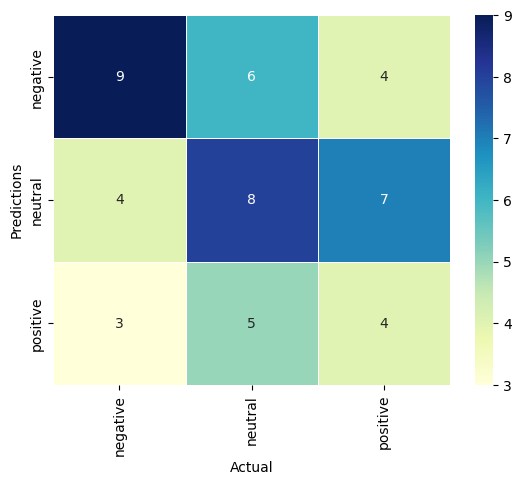

In [604]:
target_name = 'sentiment'
label_dict = {-1: 'negative', 0: 'neutral', 1: 'positive'}
print(df_tweets[target_name].unique())
labels = ['negative', 'neutral', 'positive']

# Limit the data to specific amount of tweets
n_inputs = 50
df = df_tweets.head(n_inputs)

# display the class distribution
display_class_distribution(df, target_name)

# define the prompt
instruction = "Given a list of " +  str(n_inputs) + " tweets separated by '|', " + \
f"You are a sentiment classifier. Classify the sentiment of each tweet in one of three classes - negative (-1)  neutral (0) or positive (1). Return the result as a Python dictionary with the index of each tweet and its corresponding sentiment." + \
"Remove any pre-text and post-text from the response. \nList of Tweets: "
prompt = define_prompt(instruction, df.text)

# generate a response
response = send_openai_request(prompt)

# clean the response
list_response = clean_response(response)
check_response(list_response, n_inputs)

# compare actual and predicted sentiment
openai_pred = pd.DataFrame({'openai_pred': list_response}).openai_pred.map(label_dict) 
df_result = df.join(openai_pred)

# # Evaluate model performance
model_score_tweets = evaluate_results(df_result, target_name, labels)

# Step #4 Evaluate Sentiment of Stock Market Tweets

[ 1 -1]
                                                Text  Sentiment
0  Kickers on my watchlist XIDE TIT SOQ PNK CPW B...          1
1  user: AAP MOVIE. 55% return for the FEA/GEED i...          1
2  user I'd be afraid to short AMZN - they are lo...          1
tokens: 704
Number of inputs: 50
Prompt: You are a sentiment classifier. Below you receive a list with 50 tweets, separated by |.Your job is to classify the tweets into sentiment classes with -1 for negative and 1 for positive. Return the result as a python dictionary with the index and the classifications.Remove any pre-text and post-text. 
List of Tweets: Kickers on my watchlist XIDE TIT SOQ PNK CPW BPZ AJ  trade method 1 or method 2, see prev posts|user: AAP MOVIE. 55% return for the FEA/GEED indicator just 15 trades for the year.  AWESOME.  |user I'd be afraid to short AMZN - they are looking like a near-monopoly in eBooks and infrastructure-as-a-service|MNTA Over 12.00  |OI  Over 21.37  |PGNX  Over 3.04  |AAP - user if so

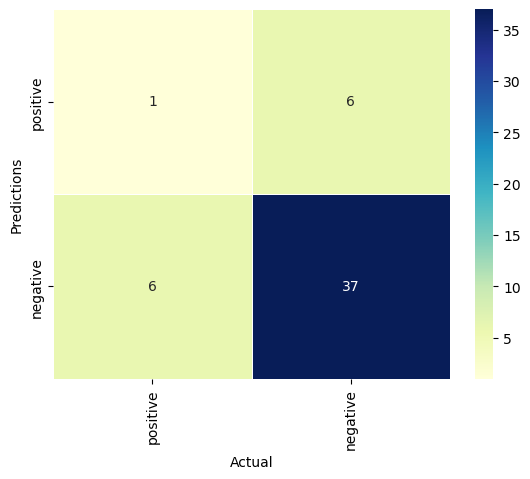

In [605]:
target_name = 'Sentiment'
#label_dict = {1: 'positive', -1: 'negative'}
print(df_stock_tweets[target_name].unique())
labels = ['positive', 'negative']

# Limit the data to specific amount of tweets
n_inputs = 50
df = df_stock_tweets.head(n_inputs)

# display the class distribution
display_class_distribution(df, target_name)

# define the prompt
instruction = "You are a sentiment classifier. Below you receive a list with " +  str(n_inputs) + " tweets, separated by |." + \
f"Your job is to classify the tweets into sentiment classes with -1 for negative and 1 for positive. Return the result as a python dictionary with the index and the classifications." + \
"Remove any pre-text and post-text. \nList of Tweets: "
prompt = define_prompt(instruction, df.Text)

# generate a response
response = send_openai_request(prompt)

# clean the response
list_response = clean_response(response)
check_response(list_response, n_inputs)

# compare actual and predicted sentiment
openai_pred = pd.DataFrame({'openai_pred': list_response}).openai_pred
df_result = df.join(openai_pred)

# # Evaluate model performance
model_score_stock_tweets = evaluate_results(df_result, target_name, labels)

# Step #5 Spam Detection - Classify Mails into Spam and Ham

In [606]:
target_name = 'Category'
label_dict = {'Spam': 'spam', 'Ham': 'ham'}
df = df_spam_mails.head(n_inputs)
labels = ['ham', 'spam']

# Limit the data to specific amount of tweets
n_inputs = 50
print(df[target_name].unique())

# display the class distribution
display_class_distribution(df, target_name)

# define the prompt
instruction = "You are an email spam detector. Given a list of " +  str(n_inputs) + " emails that are separated by |. " + \
f"detect which mails are spam ('spam') and which are not spam ('ham'). Return a python dictionary that contains the input index and the corresponding classifications. " + \
"Remove any pre-text and post-text. \nList of Tweets: "
prompt = define_prompt(instruction, df.Message)

# generate a response
response = send_openai_request(prompt)

# clean the response
list_response = clean_response(response)
check_response(list_response, n_inputs)

# compare actual and predicted sentiment
openai_pred = pd.DataFrame({'openai_pred': list_response}).openai_pred
df_result = df.join(openai_pred)

# # Evaluate model performance
model_score_spam_mails = evaluate_results(df_result, target_name, labels)

['ham' 'spam']
  Category                                            Message
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
tokens: 916
Number of inputs: 50
Prompt: You are an email spam detector. Given a list of 50 emails that are separated by |. detect which mails are spam ('spam') and which are not spam ('ham'). Return a python dictionary that contains the input index and the corresponding classifications. Remove any pre-text and post-text. 
List of Tweets: Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...|Ok lar... Joking wif u oni...|Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's|U dun say so early hor... U c already then say...|Nah I don't think he goes to usf, he lives aroun

# Step #6 Performance Overview

(0.6559649122807018, 0.58, 0.5929431438127091, None)
(0.6483720930232557, 0.68, 0.6638095238095238, None)
(0.652, 0.68, 0.6617543859649122, None)


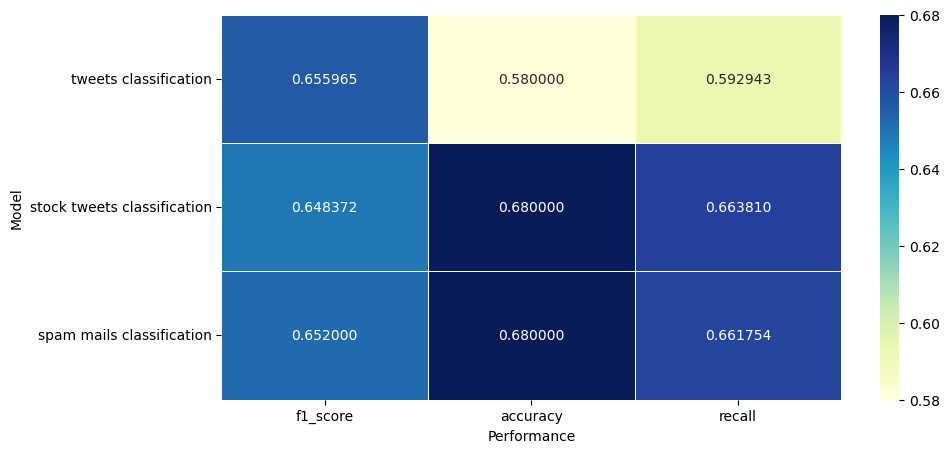

In [ ]:
performance_dict = {'tweets classification': model_score_tweets,
                    'stock tweets classification': model_score_stock_tweets,
                    'spam mails classification': model_score_spam_mails}

performance_df = pd.DataFrame()

#loop over performance_dict and append the results to performance_df
for model_name, model_score in performance_dict.items():
    print(model_score)
    data_dict = {'model_name': model_name, 
                    'f1_score': model_score[0], 
                    'accuracy': model_score[1], 
                    'recall': model_score[2]}
    # concat the data_dict to performance_df
    performance_df = pd.concat([performance_df, pd.DataFrame(data_dict, index=[0])], axis=0)

performance_df
performance_df = performance_df.set_index('model_name')

performance_df

# plot the performance_df and add the absolute values to the plot using seaborn
fig, ax = plt.subplots(figsize=(10, 5))
sns.heatmap(performance_df, annot=True, fmt="f", linewidths=.5, cmap="YlGnBu", ax=ax)
plt.ylabel('Model'); plt.xlabel('Performance')
plt.show()